<a href="https://colab.research.google.com/github/brancatellimat/speech-emotion-recognition/blob/main/CNNClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tqdm import tqdm

import os
import sys
import math

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import librosa.feature as libf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, minmax_scale, scale, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

from scipy.stats import kurtosis
from scipy.stats import skew

eps = sys.float_info.epsilon

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

### CNN with only train-test split (98% accuracy)

In [ ]:
features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Audio Pattern Recognition/Project_Brancatelli/features.csv')
features.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.214355,0.319824,0.429688,0.423340,0.421875,0.436035,0.427734,0.434570,0.426758,0.397949,...,-21.660831,-8.824115,7.443534,5.859727,-0.321161,-15.598403,-11.630619,-11.754715,4.756393,angry
1,0.253906,0.388184,0.514648,0.510254,0.506836,0.495117,0.493164,0.479492,0.486816,0.495117,...,-20.565357,-6.349044,8.264988,5.284755,0.973508,-13.907689,-12.484719,-9.336018,3.070137,angry
2,0.218750,0.323730,0.421387,0.418945,0.411133,0.416016,0.416992,0.416504,0.404785,0.382324,...,-11.227339,-2.053445,11.747261,7.627929,-12.674572,-24.245716,-4.193148,3.420844,23.195007,angry
3,0.249512,0.368164,0.495117,0.497559,0.496094,0.491211,0.495605,0.499512,0.498047,0.508301,...,-11.301952,1.284632,9.955471,6.450918,-15.117396,-19.702325,-4.617732,2.827433,19.260487,angry
4,0.312500,0.495605,0.720215,0.666016,0.688477,0.586914,0.575684,0.666992,0.578125,0.670410,...,-0.363573,-0.588626,-0.576606,-0.317693,0.132963,0.652741,1.079558,1.260494,1.101743,disgust


In [ ]:
print(features.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [ ]:
features=features.fillna(0)
features.shape

(33992, 2377)

In [ ]:
X = features.iloc[:, :-1]
Y = features['Emotions']

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
print(Y.shape)
X.shape

(33992, 6)


(33992, 2376)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27193, 2376), (27193, 6), (6799, 2376), (6799, 6))

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='accuracy', save_best_only=True)

In [ ]:
early_stop=EarlyStopping(monitor='accuracy',mode='auto',patience=10,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27193, 2376), (27193, 6), (6799, 2376), (6799, 6))

In [ ]:
#Reshape for CNN MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((27193, 2376, 1), (27193, 6), (6799, 2376, 1), (6799, 6))

In [ ]:
import tensorflow.keras.layers as L

model1 = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 2376, 512)         3072      
                                                                 
 batch_normalization_24 (Ba  (None, 2376, 512)         2048      
 tchNormalization)                                               
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 1188, 512)         0         
 ng1D)                                                           
                                                                 
 conv1d_21 (Conv1D)          (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_25 (Ba  (None, 1188, 512)         2048      
 tchNormalization)                                               
                                                      

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
with tf.device(device_name):
  history=model1.fit(x_traincnn, y_train, epochs=100, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/100
425/425 [==============================] - ETA: 0s - loss: 1.5567 - accuracy: 0.3864

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


425/425 [==============================] - 141s 320ms/step - loss: 1.5567 - accuracy: 0.3864 - val_loss: 1.9185 - val_accuracy: 0.2474 - lr: 0.0010
Epoch 2/100
425/425 [==============================] - 139s 327ms/step - loss: 1.3612 - accuracy: 0.4551 - val_loss: 1.5163 - val_accuracy: 0.4008 - lr: 0.0010
Epoch 3/100
425/425 [==============================] - 139s 328ms/step - loss: 1.2638 - accuracy: 0.4985 - val_loss: 1.3206 - val_accuracy: 0.4898 - lr: 0.0010
Epoch 4/100
425/425 [==============================] - 139s 328ms/step - loss: 1.1645 - accuracy: 0.5430 - val_loss: 1.2544 - val_accuracy: 0.5149 - lr: 0.0010
Epoch 5/100
425/425 [==============================] - 139s 327ms/step - loss: 1.0719 - accuracy: 0.5852 - val_loss: 1.1276 - val_accuracy: 0.5621 - lr: 0.0010
Epoch 6/100
425/425 [==============================] - 139s 327ms/step - loss: 0.9487 - accuracy: 0.6377 - val_loss: 1.0479 - val_accuracy: 0.6027 - lr: 0.0010
Epoch 7/100
425/425 [==============================]

In [ ]:
print("Accuracy of our model on test data : " , model1.evaluate(x_testcnn,y_test)[1]*100 , "%")

#epochs = [i for i in range(85)]
#fig , ax = plt.subplots(1,2)
#train_acc = history.history['accuracy']
#train_loss = history.history['loss']
#test_acc = history.history['val_accuracy']
#test_loss = history.history['val_loss']

#fig.set_size_inches(20,6)
#ax[0].plot(epochs , train_loss , label = 'Training Loss')
#ax[0].plot(epochs , test_loss , label = 'Testing Loss')
#ax[0].set_title('Training & Testing Loss')
#ax[0].legend()
#ax[0].set_xlabel("Epochs")

#ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
#ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
#ax[1].set_title('Training & Testing Accuracy')
#ax[1].legend()
#ax[1].set_xlabel("Epochs")
#plt.show()

In [ ]:
# predicting on test data.
pred_test = model1.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

### CNN with train-test-val split
- batch size 128

In [ ]:
features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Audio Pattern Recognition/Project_Brancatelli/features.csv')
features.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.214355,0.319824,0.429688,0.423340,0.421875,0.436035,0.427734,0.434570,0.426758,0.397949,...,-21.660831,-8.824115,7.443534,5.859727,-0.321161,-15.598403,-11.630619,-11.754715,4.756393,angry
1,0.253906,0.388184,0.514648,0.510254,0.506836,0.495117,0.493164,0.479492,0.486816,0.495117,...,-20.565357,-6.349044,8.264988,5.284755,0.973508,-13.907689,-12.484719,-9.336018,3.070137,angry
2,0.218750,0.323730,0.421387,0.418945,0.411133,0.416016,0.416992,0.416504,0.404785,0.382324,...,-11.227339,-2.053445,11.747261,7.627929,-12.674572,-24.245716,-4.193148,3.420844,23.195007,angry
3,0.249512,0.368164,0.495117,0.497559,0.496094,0.491211,0.495605,0.499512,0.498047,0.508301,...,-11.301952,1.284632,9.955471,6.450918,-15.117396,-19.702325,-4.617732,2.827433,19.260487,angry
4,0.312500,0.495605,0.720215,0.666016,0.688477,0.586914,0.575684,0.666992,0.578125,0.670410,...,-0.363573,-0.588626,-0.576606,-0.317693,0.132963,0.652741,1.079558,1.260494,1.101743,disgust


In [ ]:
print(features.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [ ]:
features=features.fillna(0)
features.shape

(33992, 2377)

In [ ]:
X = features.iloc[:, :-1]
Y = features['Emotions']

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
print(Y.shape)
X.shape

(33992, 6)


(33992, 2376)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=0, shuffle=True) # 0.25 x 0.8 = 0.2

In [ ]:
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((20394, 2376), (6799, 2376), (6799, 2376), (20394, 6), (6799, 6), (6799, 6))

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('model_weights.h5', monitor='accuracy', save_best_only=True)

In [ ]:
early_stop=EarlyStopping(monitor='accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((20394, 2376), (6799, 2376), (6799, 2376), (20394, 6), (6799, 6), (6799, 6))

In [ ]:
#Reshape for CNN MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_valcnn = np.expand_dims(x_val, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((20394, 2376, 1), (20394, 6), (6799, 2376, 1), (6799, 6))

In [ ]:
import tensorflow.keras.layers as L

model2 = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 2376, 512)         3072      
                                                                 
 batch_normalization_6 (Bat  (None, 2376, 512)         2048      
 chNormalization)                                                
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 1188, 512)         0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_7 (Bat  (None, 1188, 512)         2048      
 chNormalization)                                                
                                                      

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
with tf.device(device_name):
  history=model2.fit(x_traincnn, y_train, epochs=100, validation_data=(x_valcnn, y_val), batch_size=128,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/100
160/160 [==============================] - 117s 641ms/step - loss: 1.6442 - accuracy: 0.3699 - val_loss: 2.1777 - val_accuracy: 0.2364 - lr: 0.0010
Epoch 2/100
160/160 [==============================] - ETA: 0s - loss: 1.3716 - accuracy: 0.4481

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 104s 647ms/step - loss: 1.3716 - accuracy: 0.4481 - val_loss: 2.0174 - val_accuracy: 0.2549 - lr: 0.0010
Epoch 3/100
160/160 [==============================] - 104s 651ms/step - loss: 1.2826 - accuracy: 0.4927 - val_loss: 1.5668 - val_accuracy: 0.3584 - lr: 0.0010
Epoch 4/100
160/160 [==============================] - 104s 652ms/step - loss: 1.2013 - accuracy: 0.5254 - val_loss: 1.9309 - val_accuracy: 0.3879 - lr: 0.0010
Epoch 5/100
160/160 [==============================] - 104s 652ms/step - loss: 1.1126 - accuracy: 0.5633 - val_loss: 1.3989 - val_accuracy: 0.4508 - lr: 0.0010
Epoch 6/100
160/160 [==============================] - 104s 652ms/step - loss: 1.0422 - accuracy: 0.5981 - val_loss: 1.2340 - val_accuracy: 0.5270 - lr: 0.0010
Epoch 7/100
160/160 [==============================] - 104s 652ms/step - loss: 0.9444 - accuracy: 0.6408 - val_loss: 1.4787 - val_accuracy: 0.4757 - lr: 0.0010
Epoch 8/100
160/160 [==============================]

213/213 [==============================] - 11s 44ms/step - loss: 0.3631 - accuracy: 0.9191
Accuracy of our model on test data :  91.91057682037354 %


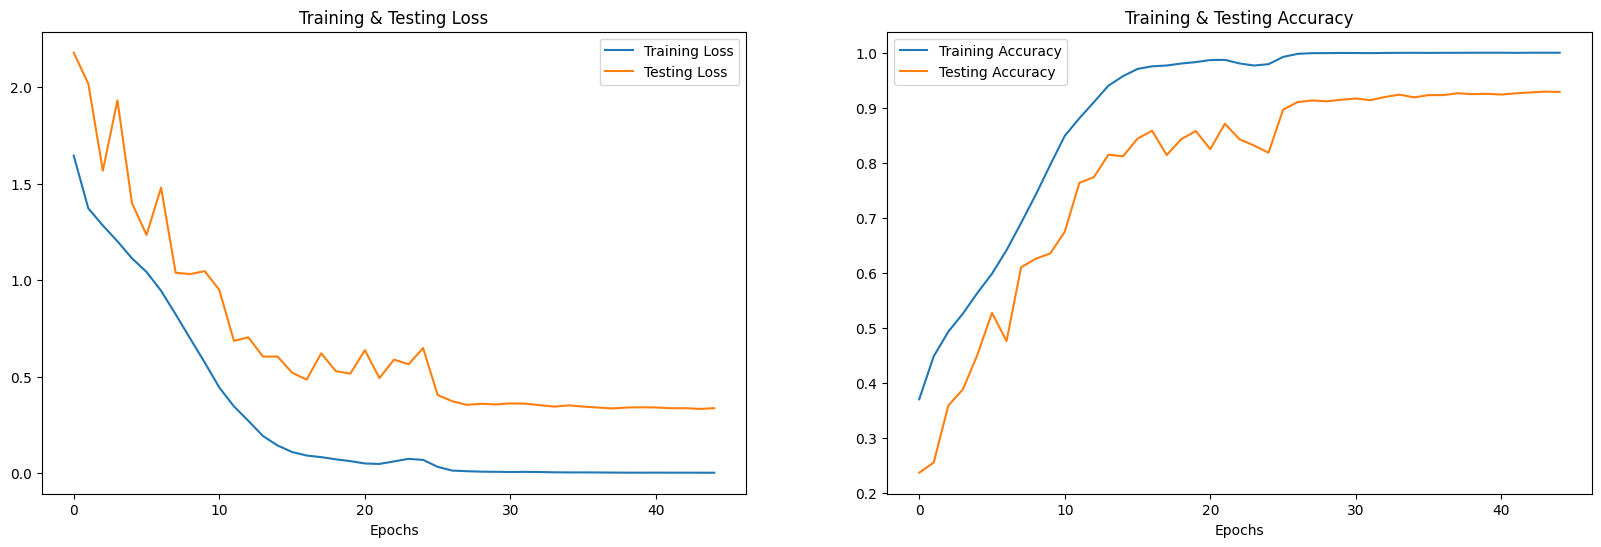

In [ ]:
print("Accuracy of our model on test data : " , model2.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(45)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model2.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

213/213 [==============================] - 9s 43ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,fear,fear
2,neutral,neutral
3,fear,fear
4,happy,happy
5,fear,fear
6,neutral,neutral
7,angry,angry
8,angry,angry
9,happy,happy


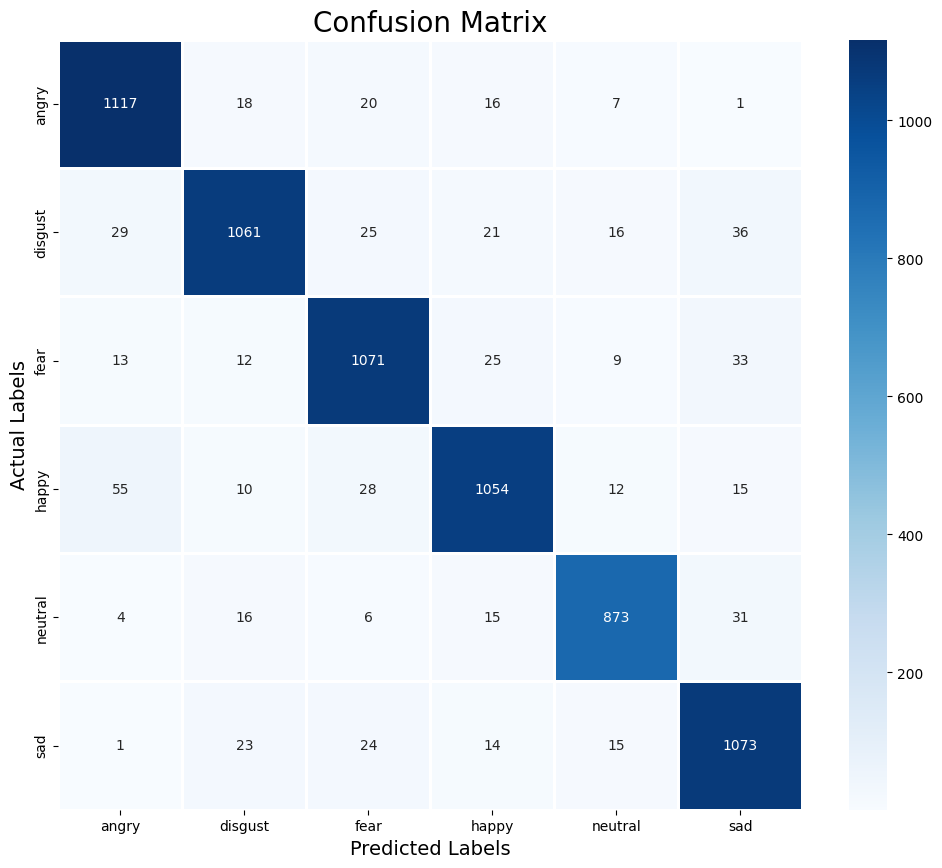

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.92      0.95      0.93      1179
     disgust       0.93      0.89      0.91      1188
        fear       0.91      0.92      0.92      1163
       happy       0.92      0.90      0.91      1174
     neutral       0.94      0.92      0.93       945
         sad       0.90      0.93      0.92      1150

    accuracy                           0.92      6799
   macro avg       0.92      0.92      0.92      6799
weighted avg       0.92      0.92      0.92      6799



### CNN with train-test-val split
- batch size 32

In [ ]:
features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Audio Pattern Recognition/Project_Brancatelli/features.csv')
features.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.214355,0.319824,0.429688,0.423340,0.421875,0.436035,0.427734,0.434570,0.426758,0.397949,...,-21.660831,-8.824115,7.443534,5.859727,-0.321161,-15.598403,-11.630619,-11.754715,4.756393,angry
1,0.253906,0.388184,0.514648,0.510254,0.506836,0.495117,0.493164,0.479492,0.486816,0.495117,...,-20.565357,-6.349044,8.264988,5.284755,0.973508,-13.907689,-12.484719,-9.336018,3.070137,angry
2,0.218750,0.323730,0.421387,0.418945,0.411133,0.416016,0.416992,0.416504,0.404785,0.382324,...,-11.227339,-2.053445,11.747261,7.627929,-12.674572,-24.245716,-4.193148,3.420844,23.195007,angry
3,0.249512,0.368164,0.495117,0.497559,0.496094,0.491211,0.495605,0.499512,0.498047,0.508301,...,-11.301952,1.284632,9.955471,6.450918,-15.117396,-19.702325,-4.617732,2.827433,19.260487,angry
4,0.312500,0.495605,0.720215,0.666016,0.688477,0.586914,0.575684,0.666992,0.578125,0.670410,...,-0.363573,-0.588626,-0.576606,-0.317693,0.132963,0.652741,1.079558,1.260494,1.101743,disgust


In [ ]:
print(features.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [ ]:
features=features.fillna(0)
features.shape

(33992, 2377)

In [ ]:
X = features.iloc[:, :-1]
Y = features['Emotions']

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
print(Y.shape)
X.shape

(33992, 6)


(33992, 2376)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=0, shuffle=True) # 0.25 x 0.8 = 0.2

In [ ]:
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((20394, 2376), (6799, 2376), (6799, 2376), (20394, 6), (6799, 6), (6799, 6))

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='accuracy', save_best_only=True)

In [ ]:
early_stop=EarlyStopping(monitor='accuracy',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((20394, 2376), (6799, 2376), (6799, 2376), (20394, 6), (6799, 6), (6799, 6))

In [ ]:
#Reshape for CNN MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_valcnn = np.expand_dims(x_val, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((20394, 2376, 1), (20394, 6), (6799, 2376, 1), (6799, 6))

In [ ]:
import tensorflow.keras.layers as L

model3 = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])
model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 512)         3072      
                                                                 
 batch_normalization (Batch  (None, 2376, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 1188, 512)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_1 (Bat  (None, 1188, 512)         2048      
 chNormalization)                                                
                                                        

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
with tf.device(device_name):
  history=model3.fit(x_traincnn, y_train, epochs=100, validation_data=(x_valcnn, y_val), batch_size=32,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/100
638/638 [==============================] - 118s 168ms/step - loss: 1.6230 - accuracy: 0.3579 - val_loss: 1.5358 - val_accuracy: 0.4076 - lr: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


638/638 [==============================] - 110s 172ms/step - loss: 1.4191 - accuracy: 0.4251 - val_loss: 1.4347 - val_accuracy: 0.4248 - lr: 0.0010
Epoch 3/100
638/638 [==============================] - 110s 173ms/step - loss: 1.3191 - accuracy: 0.4727 - val_loss: 1.3922 - val_accuracy: 0.4471 - lr: 0.0010
Epoch 4/100
638/638 [==============================] - 110s 173ms/step - loss: 1.2447 - accuracy: 0.5081 - val_loss: 1.2834 - val_accuracy: 0.4955 - lr: 0.0010
Epoch 5/100
638/638 [==============================] - 110s 173ms/step - loss: 1.1709 - accuracy: 0.5367 - val_loss: 1.2335 - val_accuracy: 0.4995 - lr: 0.0010
Epoch 6/100
638/638 [==============================] - 110s 173ms/step - loss: 1.0998 - accuracy: 0.5756 - val_loss: 1.2181 - val_accuracy: 0.5307 - lr: 0.0010
Epoch 7/100
638/638 [==============================] - 110s 173ms/step - loss: 0.9941 - accuracy: 0.6170 - val_loss: 1.2174 - val_accuracy: 0.5470 - lr: 0.0010
Epoch 8/100
638/638 [==============================]

213/213 [==============================] - 10s 45ms/step - loss: 0.3811 - accuracy: 0.9262
Accuracy of our model on test data :  92.61656403541565 %


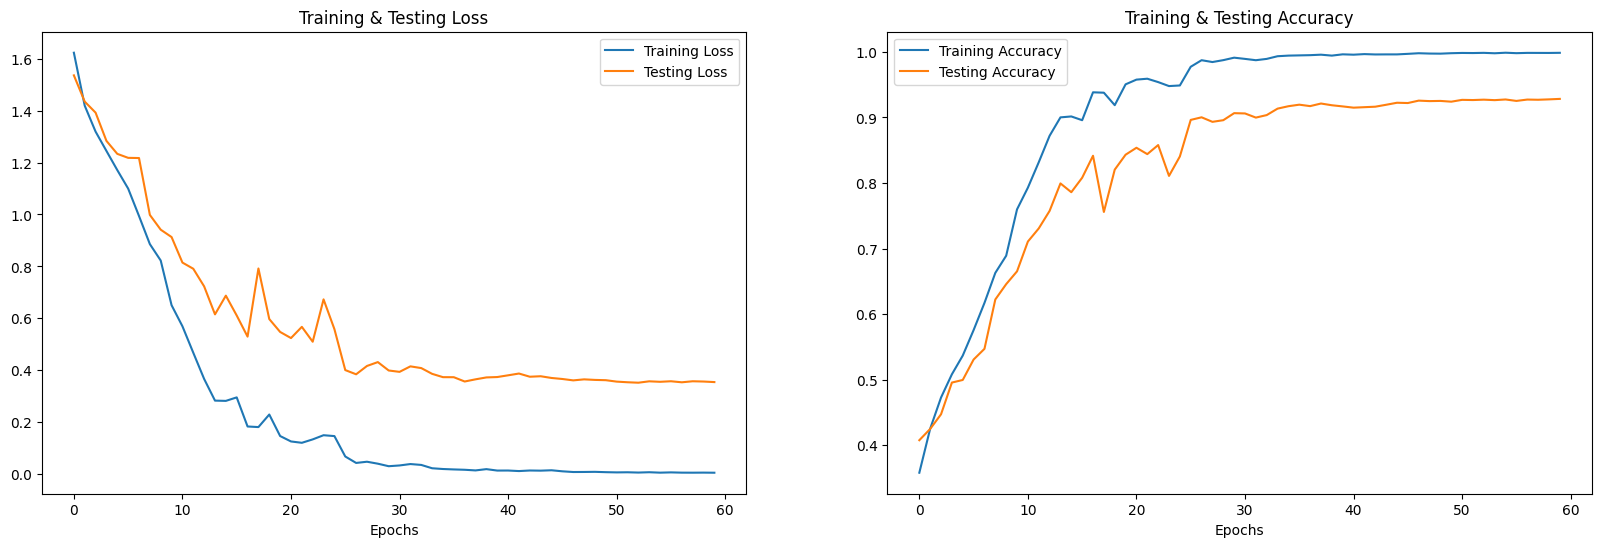

In [ ]:
print("Accuracy of our model on test data : " , model3.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(60)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model3.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

213/213 [==============================] - 9s 44ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,fear,fear
2,neutral,neutral
3,fear,fear
4,happy,happy
5,fear,fear
6,neutral,neutral
7,angry,angry
8,angry,angry
9,happy,happy


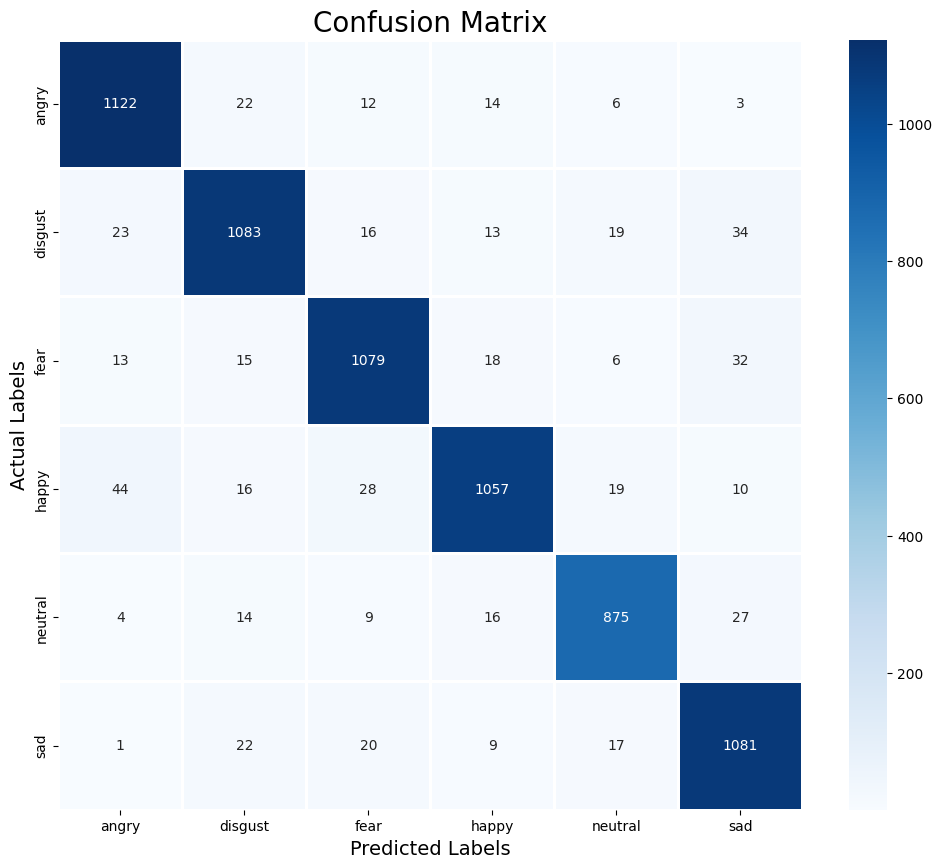

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.93      0.95      0.94      1179
     disgust       0.92      0.91      0.92      1188
        fear       0.93      0.93      0.93      1163
       happy       0.94      0.90      0.92      1174
     neutral       0.93      0.93      0.93       945
         sad       0.91      0.94      0.93      1150

    accuracy                           0.93      6799
   macro avg       0.93      0.93      0.93      6799
weighted avg       0.93      0.93      0.93      6799

